# BIDS Loader


We use the data in `SpineGeneric`

In [1]:
from bids_neuropoly import bids
from medicaltorch import datasets as mt_datasets
from medicaltorch import transforms as mt_transforms
from medicaltorch import filters as mt_filters

from PIL import Image


class SliceFilter(mt_filters.SliceFilter):
    """This class extends the SliceFilter that already
    filters for empty labels and inputs. It will filter
    slices that has only zeros after cropping. To avoid
    feeding empty inputs into the network.
    """
    def __call__(self, sample):
        super_ret = super().__call__(sample)

        # Already filtered by base class
        if not super_ret:
            return super_ret

        # Filter slices where there are no values after cropping
        input_img = Image.fromarray(sample['input'], mode='F')
        input_cropped = transforms.functional.center_crop(input_img, (128, 128))
        input_cropped = np.array(input_cropped)
        count = np.count_nonzero(input_cropped)

        if count <= 0:
            return False

        return True
    
class BIDSSegPair2D(mt_datasets.SegmentationPair2D):
    def __init__(self, input_filename, gt_filename, metadata):
        super().__init__(input_filename, gt_filename)
        self.metadata = metadata
        self.metadata["input_filename"] = input_filename
        self.metadata["gt_filename"] = gt_filename

    def get_pair_slice(self, slice_index, slice_axis=2):
        dreturn = super().get_pair_slice(slice_index, slice_axis)
        self.metadata["slice_index"] = slice_index
        dreturn["input_metadata"]["bids_metadata"] = self.metadata
        return dreturn


class MRI2DBidsSegDataset(mt_datasets.MRI2DSegmentationDataset):
    def _load_filenames(self):
        for input_filename, gt_filename, bids_metadata in self.filename_pairs:
            segpair = BIDSSegPair2D(input_filename, gt_filename,
                                    bids_metadata)
            self.handlers.append(segpair)


class BidsDataset(MRI2DBidsSegDataset):
    def __init__(self, root_dir, slice_axis=2, cache=True,
                 transform=None, slice_filter_fn=None,
                 canonical=False, labeled=True):
        self.bids_ds = bids.BIDS(root_dir)
        self.filename_pairs = []
        self.metadata = {"FlipAngle": [], "RepetitionTime": [], "EchoTime": [], "Manufacturer": []}

        for subject in self.bids_ds.get_subjects():

            if not subject.has_derivative("labels"):
                print("Subject without derivative, skipping.")
                continue
            derivatives = subject.get_derivatives("labels")
            cord_label_filename = None

            for deriv in derivatives:
                if deriv.endswith("seg-manual.nii.gz"):
                    cord_label_filename = deriv

            if cord_label_filename is None:
                continue

            if not subject.has_metadata():
                print("Subject without metadata.")
                continue

            metadata = subject.metadata()
            

            self.filename_pairs.append((subject.record.absolute_path,
                                        cord_label_filename, metadata))

        super().__init__(self.filename_pairs, slice_axis, cache,
                         transform, slice_filter_fn, canonical)


In [2]:
mt_transforms.F.center_crop

<function torchvision.transforms.functional.center_crop(img, output_size)>

# Model

Here we define the architecture of the network in a PyTorch Module

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class DownConv(nn.Module):
    def __init__(self, in_ch, out_ch, drop_rate=0.2, bn_momentum=0.1):
        super(DownConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, stride=1, padding=1)
        self.conv_bn = nn.BatchNorm2d(out_ch, momentum=bn_momentum)
        self.conv_drop = nn.Dropout2d(drop_rate)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.conv_bn(x)
        x = self.conv_drop(x)
        return x

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Classifier(nn.Module):
    def __init__(self, drop_rate=0.2, bn_momentum=0.1):
        super(Classifier, self).__init__()
        self.conv1 = DownConv(1, 32, drop_rate, bn_momentum)
        self.mp1 = nn.MaxPool2d(2)
        
        self.conv2 = DownConv(32, 32, drop_rate, bn_momentum)
        self.mp2 = nn.MaxPool2d(2)
        
        self.conv3 = DownConv(32, 64, drop_rate, bn_momentum)
        self.mp3 = nn.MaxPool2d(2)       
        
        self.flat = Flatten()
        self.dense1 = nn.Linear(16384, 512)
        self.drop = nn.Dropout2d(drop_rate)
        self.dense2 = nn.Linear(512, 6)
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.mp1(x1)
        
        x3 = self.conv2(x2)
        x4 = self.mp2(x3)
        
        x5 = self.conv3(x4)
        x6 = self.mp3(x5)
        
        x7 = self.flat(x6)
        x8 = F.relu(self.dense1(x7))
        x9 = self.drop(x8)
        x10 = self.dense2(x9)
        x11 = self.soft(x10)

        return(x11)

#torch tensors are of the format (batch_size, n_channels, shape_of_image)
a = torch.rand(18,1,128,128)
test = Classifier().forward(a)

# Training the model

In [4]:
from tensorboardX import SummaryWriter
import time
import shutil
import sys
import pickle
import nibabel as nib
import numpy as np
import json
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from skimage.transform import resize

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, ConcatDataset

from sklearn import metrics

import torch.backends.cudnn as cudnn
cudnn.benchmark = True



def get_modality(batch):
    labels = []
    for acq in batch['input_metadata']:
        path = acq.__getitem__('bids_metadata')['input_filename']
        name = os.path.basename(path)
        if "acq-MToff_MTS" in name :
            labels.append(0)
            continue
        if "acq-MTon_MTS" in name :
            labels.append(1)
            continue
        if "acq-T1w_MTS" in name :
            labels.append(2)
            continue
        if "T1w" in name :
            labels.append(3)
            continue
        if "T2star" in name :
            labels.append(4)
            continue
        if "T2w" in name :
            labels.append(5) 
            continue
    return labels

def OneHotEncode(labels):
    ohe_labels = []
    for label in labels :
        ohe = [0 for i in range(6)]
        ohe[label] = 1 
        ohe_labels.append(ohe)
    return torch.cuda.FloatTensor(ohe_labels)


def cmd_train(context):
    """Main command do train the network.
    :param context: this is a dictionary with all data from the
                    configuration file:
                        - 'command': run the specified command (e.g. train, test)
                        - 'gpu': ID of the used GPU
                        - 'bids_path_train': list of relative paths of the BIDS folders of each training center
                        - 'bids_path_validation': list of relative paths of the BIDS folders of each validation center
                        - 'bids_path_test': list of relative paths of the BIDS folders of each test center
                        - 'batch_size'
                        - 'dropout_rate'
                        - 'batch_norm_momentum'
                        - 'num_epochs'
                        - 'initial_lr': initial learning rate
                        - 'log_directory': folder name where log files are saved
                        - 'debugging': allows extended verbosity and intermediate outputs
    """
    # Set the GPU
    gpu_number = int(0)
    torch.cuda.set_device(gpu_number)

    # These are the training transformations
    train_transform = transforms.Compose([
        mt_transforms.CenterCrop2D((128, 128)),
        mt_transforms.ElasticTransform(alpha_range=(28.0, 30.0),
                                       sigma_range=(3.5, 4.0),
                                       p=0.3),
        mt_transforms.RandomAffine(degrees=4.6,
                                   scale=(0.98, 1.02),
                                   translate=(0.03, 0.03)),
        mt_transforms.RandomTensorChannelShift((-0.10, 0.10)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
    ])

    # These are the validation/testing transformations
    val_transform = transforms.Compose([
        mt_transforms.CenterCrop2D((128, 128)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
    ])

    # This code will iterate over the folders and load the data, filtering
    # the slices without labels and then concatenating all the datasets together
    train_datasets = []
    for bids_ds in tqdm_notebook(context["bids_path_train"], desc="Loading training set"):
        ds_train = BidsDataset(bids_ds,
                               transform=train_transform,
                               slice_filter_fn=SliceFilter())
        train_datasets.append(ds_train)

    ds_train = ConcatDataset(train_datasets)
    print(f"Loaded {len(ds_train)} axial slices for the training set.")
    train_loader = DataLoader(ds_train, batch_size=context["batch_size"],
                              shuffle=True, pin_memory=True,
                              collate_fn=mt_datasets.mt_collate,
                              num_workers=1)
    
    # Validation dataset ------------------------------------------------------
    validation_datasets = []
    for bids_ds in tqdm_notebook(context["bids_path_validation"], desc="Loading validation set"):
        ds_val = BidsDataset(bids_ds,
                             transform=val_transform,
                             slice_filter_fn=SliceFilter())
        validation_datasets.append(ds_val)

    ds_val = ConcatDataset(validation_datasets)
    print(f"Loaded {len(ds_val)} axial slices for the validation set.")
    val_loader = DataLoader(ds_val, batch_size=context["batch_size"],
                            shuffle=True, pin_memory=True,
                            collate_fn=mt_datasets.mt_collate,
                            num_workers=0)
    
    
    # Model definition ---------------------------------------------------------
    model = Classifier(drop_rate=context["dropout_rate"],
                       bn_momentum=context["batch_norm_momentum"])

    model.cuda()

    num_epochs = context["num_epochs"]
    initial_lr = context["initial_lr"]

    # Using SGD with cosine annealing learning rate
    optimizer = optim.SGD(model.parameters(), lr=initial_lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    # Write the metrics, images, etc to TensorBoard format
    writer = SummaryWriter(log_dir=context["log_directory"])
    
    # Binary Cross Entropy Loss
    criterion = nn.CrossEntropyLoss()
    
    
    # Training loop -----------------------------------------------------------
    best_validation_loss = float("inf")
    
    lst_train_loss = []
    lst_val_loss = []
    lst_accuracy = []
    
    for epoch in tqdm_notebook(range(1, num_epochs+1), desc="Training"):
        start_time = time.time()

        scheduler.step()

        lr = scheduler.get_lr()[0]
        writer.add_scalar('learning_rate', lr, epoch)

        model.train()
        train_loss_total = 0.0
        num_steps = 0
    
        for i, batch in enumerate(train_loader):
            input_samples = batch["input"]
            input_labels = get_modality(batch)
            
            var_input = input_samples.cuda()
            var_labels = torch.cuda.LongTensor(input_labels).cuda(non_blocking=True)

            outputs = model(var_input)
            
            loss = criterion(outputs, var_labels)
            train_loss_total += loss.item()

            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()
            num_steps += 1
            
        train_loss_total_avg = train_loss_total / num_steps
        lst_train_loss.append(train_loss_total_avg)
        
        #tqdm.write(f"Epoch {epoch} training loss: {train_loss_total_avg:.4f}.")
        print(f"Epoch {epoch} training loss: {train_loss_total_avg:.4f}.")
        
        
        # Validation loop -----------------------------------------------------
        model.eval()
        val_loss_total = 0.0
        num_steps = 0
        
        val_accuracy = 0
        num_samples = 0
    
        
        for i, batch in enumerate(val_loader):
            input_samples = batch["input"]
            input_labels = get_modality(batch)
            
            with torch.no_grad():
                var_input = input_samples.cuda()
                var_labels = torch.cuda.LongTensor(input_labels).cuda(non_blocking=True)

                outputs = model(var_input)
                _, preds = torch.max(outputs, 1)

                loss = criterion(outputs, var_labels)
                val_loss_total += loss.item()
                
                val_accuracy += int((var_labels == preds).sum())
                
            num_steps += 1
            num_samples += context['batch_size']
            
        val_loss_total_avg = val_loss_total / num_steps
        lst_val_loss.append(val_loss_total_avg)
        
        #tqdm.write(f"Epoch {epoch} validation loss: {val_loss_total_avg:.4f}.")
        print(f"Epoch {epoch} validation loss: {val_loss_total_avg:.4f}.")
        
        val_accuracy_avg = 100 * val_accuracy / num_samples
        lst_accuracy.append(val_accuracy_avg)
        
        #tqdm.write(f"Epoch {epoch} accuracy : {val_accuracy_avg:.4f}.")
        print(f"Epoch {epoch} accuracy : {val_accuracy_avg:.4f} %.")
        
        #add metrics for tensorboard
        writer.add_scalars('accuracy', val_accuracy_avg, epoch)
        writer.add_scalars('losses', {
            'train_loss': train_loss_total_avg,
            'val_loss': val_loss_total_avg,
        }, epoch)
        
        end_time = time.time()
        total_time = end_time - start_time
        #tqdm.write("Epoch {} took {:.2f} seconds.".format(epoch, total_time))
        print("Epoch {} took {:.2f} seconds.".format(epoch, total_time))
        
        
        if val_loss_total_avg < best_validation_loss:
            best_validation_loss = val_loss_total_avg
            torch.save(model, "./"+context["log_directory"]+"/best_model.pt")

        
    # save final model
    torch.save(model, "./"+context["log_directory"]+"/final_model.pt")
    
    # display and save the metrics
    parameters = "CrossEntropyLoss, batchsize=" + str(context['batch_size'])
    parameters += ", initial_lr=" + str(context['initial_lr'])
    parameters += ", dropout=" + str(context['dropout_rate'])
    
    
    plt.subplot(2,1,1)
    plt.title(parameters)
    plt.plot(lst_train_loss, color='red', label='Training')
    plt.plot(lst_val_loss, color='blue', label='Validation')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    
    plt.subplot(2,1,2)
    plt.plot(lst_accuracy)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.savefig(parameters+'.png')
    plt.show()    
    return


def run_main(command):
    with open('config.json') as fhandle:
        context = json.load(fhandle)

    #command = context["command"]

    if command == 'train':
        cmd_train(context)
        #shutil.copyfile(sys.argv[1], "./"+context["log_directory"]+"/config_file.json")
    elif command == 'test':
        cmd_test(context)

    

In [5]:
run_main('train')

KeyboardInterrupt: 

# Testing

In [23]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from matplotlib.colors import LinearSegmentedColormap


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_metrics(metrics, acc, classes,
                title="Validation metrics",
                cmap=None):
    
    colors = [(1,1,1), (1,1,1), (1,1,1)]
    cm = LinearSegmentedColormap.from_list("white",colors,N=1)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(metrics, interpolation=None, cmap=cm)
    # We want to show all ticks...
    ax.set(xticks=np.arange(metrics.shape[1]),
           yticks=np.arange(metrics.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=["Recall", "Precision"],
           title="Accuracy over slices = "+str(int(10000*acc)/100)+"%"
)


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    for i in range(metrics.shape[0]):
        for j in range(metrics.shape[1]):
            ax.text(j, i, format(metrics[i, j], fmt),
                    ha="center", va="center",
                    color="black")
    fig.tight_layout()
    
    return ax



This is a slice by slice accuracy measurement on the test dataset

In [24]:
def cmd_test(context):

    # Set the GPU
    gpu_number = int(0)
    torch.cuda.set_device(gpu_number)

    # These are the validation/testing transformations
    val_transform = transforms.Compose([
        mt_transforms.CenterCrop2D((128, 128)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
    ])

    test_datasets = []
    for bids_ds in tqdm_notebook(context["bids_path_test"], desc="Loading test set"):
        ds_test = BidsDataset(bids_ds,
                                     transform=val_transform,
                                     slice_filter_fn=SliceFilter())
        test_datasets.append(ds_test)


    ds_test = ConcatDataset(test_datasets)
    print(f"Loaded {len(ds_test)} axial slices for the test set.")
    test_loader = DataLoader(ds_test, batch_size=context["batch_size"],
                             shuffle=True, pin_memory=True,
                             collate_fn=mt_datasets.mt_collate,
                             num_workers=1)

    model = torch.load("./"+context["log_directory"]+"/best_model.pt", map_location="cuda:0")
    model.cuda()
    model.eval()
    
    #setting the lists for confusion matrix
    true_labels = []
    guessed_labels = []

    for i, batch in enumerate(test_loader):
        input_samples = batch["input"]
        input_labels = get_modality(batch)
        
        true_labels += input_labels

        with torch.no_grad():
            test_input = input_samples.cuda()
            test_labels = torch.cuda.LongTensor(input_labels).cuda(non_blocking=True)

            outputs = model(test_input)
            _, preds = torch.max(outputs, 1)
            
            lst_labels = [int(x) for x in preds]
            guessed_labels += lst_labels
            
    accuracy = accuracy_score(true_labels, guessed_labels)
    recall = recall_score(true_labels, guessed_labels, average=None)
    precision = precision_score(true_labels, guessed_labels, average=None)
    
    np.set_printoptions(precision=2)

    class_names = ["MToff_MTS", "MTon_MTS", "T1w_MTS", "T1w", "T2star", "T2w"]
    # Plot normalized confusion matrix
    plot_confusion_matrix(true_labels, guessed_labels, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plot_metrics(np.array([recall, precision]), accuracy, class_names)
    print(f"Accuracy over test slices : {accuracy}")
    print(f"Recall over test slices : {recall}")
    print(f"Precision over test slices : {precision}")

    plt.savefig("test_accuracy.png")
    plt.show()
    
    return

Loaded 2036 axial slices for the test set.
Accuracy over test slices : 0.9356581532416502
Recall over test slices : [0.98 0.9  0.92 0.85 0.97 1.  ]
Precision over test slices : [0.95 0.93 0.87 0.95 0.93 0.99]


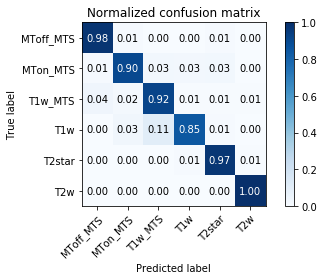

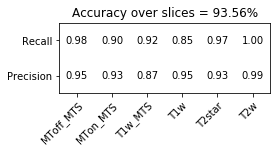

In [25]:
run_main("test")

But we want to add another tool to visualize accuracy for whole acquisitions and make sure that accuracy remains high.

In [107]:
import nibabel as nib
from sklearn.preprocessing import normalize
from statistics import mode

def transform(input_slices):
    slices = []
    for i in range(input_slices.shape[2]):
        w,h = input_slices.shape[0], input_slices.shape[1]
        c1,c2 = w//2 - 64, w//2 + 64
        c3,c4 = h//2 - 64, h//2 + 64
        
        normalized_slice = normalize(input_slices[c1:c2,c3:c4,i])
        transposed_slice = np.transpose(normalized_slice)
        slices.append(np.expand_dims(transposed_slice, axis=0))
    slices = torch.FloatTensor(slices)
    return(slices)
    
def acquisition_predict(path, model=None):
       
    slices = transform(nib.load(path).get_data())
    
    with torch.no_grad():
        slices = slices.cuda()

        outputs = model(slices)   
        _, preds = torch.max(outputs, 1)

        preds = preds.tolist()

        print(preds)
        
    modality = mode(preds)
    return(modality)

model = torch.load("./log_baseline/best_model.pt", map_location="cuda:0")
model.cuda()
model.eval()

acquisition_predict("../duke/projects/ivado-medical-imaging/spineGeneric_201904271322/result/juntendo-750w_spineGeneric/sub-02/anat/sub-02_T1w.nii.gz", model)


/home/GRAMES.POLYMTL.CA/p112175/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/GRAMES.POLYMTL.CA/p112175/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/GRAMES.POLYMTL.CA/p112175/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.module

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


2

# Numerical accuracy evaluation

Since we only measured the accuracy over each slice we have to measure the accuracy for a whole acquisition comprising several (at leat 15) tranches. If we consider the label that appears the most among the acquisition we obtain the estimated label for the acquisition.

In [ ]:
def tirage(accuracy):
    x = np.random.rand()
    if x <= accuracy:
        return([0,0,0,0,0,1])
    else:
        i = np.random.randint(4)
        l = [0 for i in range(6)]
        l[i] = 1
        return(l)
    
def montecarlo(n):
    accuracy = 0
    for i in range(n):
        # we average over 15 slices
        labels = [0 for i in range(6)]
        for j in range(15):
            t = tirage()
            labels = [x+y for x,y in zip(labels, t)]
        label = labels.index(max(labels))
        if label == 5:
            accuracy += 1
    return(100 * accuracy/n)
            
montecarlo(10000000)

So we manage to obtain a promising 99.988% accuracy for each acquisition, which is enough for a reliable release.

# Random testing

In [ ]:
with open('config_small.json') as fhandle:
        context = json.load(fhandle)

# Set the GPU
gpu_number = int(0)
torch.cuda.set_device(gpu_number)

# These are the validation/testing transformations
val_transform = transforms.Compose([
    mt_transforms.CenterCrop2D((128, 128)),
    mt_transforms.ToTensor(),
    mt_transforms.NormalizeInstance(),
])

test_datasets = []
for bids_ds in tqdm_notebook(context["bids_path_test"], desc="Loading test set"):
    ds_test = BidsDataset(bids_ds,
                                 transform=val_transform,
                                 slice_filter_fn=SliceFilter())
    test_datasets.append(ds_test)


ds_test = ConcatDataset(test_datasets)
print(f"Loaded {len(ds_test)} axial slices for the test set.")
test_loader = DataLoader(ds_test, batch_size=context["batch_size"],
                         shuffle=False, pin_memory=True,
                         collate_fn=mt_datasets.mt_collate,
                         num_workers=1)

print(test_loader)


In [ ]:
model = torch.load("./"+context["log_directory"]+"/best_model.pt", map_location="cuda:0")
model.cuda()
model.eval()

a = torch.rand(3,1,128,128)
a = a.cuda()

model(a)